In [1]:
from torchvision import models
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
# Apply the transformations needed
import torchvision.transforms as T
import time

import sys
sys.path.append('..')
from opencv_course import ImageUtil

dlab = models.segmentation.fcn_resnet101(pretrained=1).eval()

In [2]:
# Define the helper function
def decode_segmap(image, source, nc=21):
  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]


    rgb = np.stack([r, g, b], axis=2)

    # Load the foreground input image 
    foreground = cv2.imread(source)
    rgb = cv2.resize(rgb,(foreground.shape[1],foreground.shape[0]))
    
    # Change the color of foreground image to RGB 
    # and resize image to match shape of R-band in RGB output map  
    foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
#     foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))

    # Create a background image by copying foreground and converting into grayscale
    background = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)

    # convert single channel grayscale image to 3-channel grayscale image
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2RGB)

    # Convert uint8 to float
    foreground = foreground.astype(float)
    background = background.astype(float)

    # Create a binary mask of the RGB output map using the threshold value 0
    th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

    # Apply a slight blur to the mask to soften edges
    alpha = cv2.GaussianBlur(alpha, (5,5),0)

    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha.astype(float)/255

    # Multiply the foreground with the alpha matte
    foreground = cv2.multiply(alpha, foreground)  

    # Multiply the background with ( 1 - alpha )
    background = cv2.multiply(1.0 - alpha, background)  

    # Add the masked foreground and background
    outImage = cv2.add(foreground, background)

    # Return a normalized output image for display
    return outImage/255

In [5]:
def segment(net, path, dev='cuda'):
    img = Image.open(path)
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(150), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    now = time.time()
    
    #GPU
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    #CPU
#     inp = trf(img).unsqueeze(0)
#     out = net(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    print("Used {}s".format(time.time() -now))
    rgb = decode_segmap(om, path)
    print("Used {}s".format(time.time() -now))
    
    ImageUtil.imshow([np.array(img), np.array(rgb)], columns=2, rows=1, figsize=(15,10), cvtColor=None)

Used 3.1922638416290283s
Used 5.065221548080444s


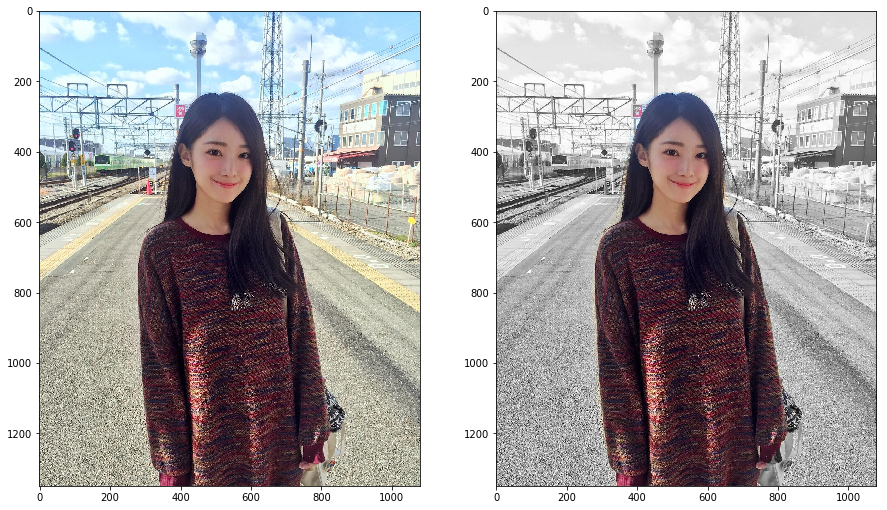

In [6]:
segment(dlab, './images/change/girl4.jpg')